**DATA LOADING**

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Define the file path
file_path = '../data/CreditCardData.csv'

# Load the dataset
df = pd.read_csv(file_path)

print("✅ Data loaded successfully!")

# --- Initial Exploration ---

# Display the first 5 rows to see the data
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Get a concise summary of the dataframe
print("\nDataset Information:")
df.info()

# Check for any missing values in each column
print("\nChecking for missing values:")
print(df.isnull().sum())

✅ Data loaded successfully!

First 5 rows of the dataset:


,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Transaction ID          100000 non-null  object 
 1   Date                    100000 non-null  object 
 2   Day of Week             100000 non-null  object 
 3   Time                    100000 non-null  int64  
 4   Type of Card            100000 non-null  object 
 5   Entry Mode              100000 non-null  object 
 6   Amount                  99994 non-null   object 
 7   Type of Transaction     100000 non-null  object 
 8   Merchant Group          99990 non-null   object 
 9   Country of Transaction  100000 non-null  object 
 10  Shipping Address        99995 non-null   object 
 11  Country of Residence    100000 non-null  object 
 12  Gender                  99996 non-null   object 
 13  Age                     100000 non-null  float64
 14 

**Data Cleaning**

In [3]:
# 1. Clean the 'Amount' column
# Remove the pound symbol '£'
df['Amount'] = df['Amount'].str.replace('£', '', regex=False)
# Convert column to a numeric type, turning any errors into NaN (Not a Number)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# 2. Drop all rows that have any missing value
# This will now also handle any rows where 'Amount' failed to convert
df.dropna(inplace=True)

# 3. Verify the cleaning process
print("✅ Data cleaning complete.")
print(f"Total missing values remaining: {df.isnull().sum().sum()}")
print(f"DataFrame shape after cleaning: {df.shape}")

✅ Data cleaning complete.
Total missing values remaining: 0
DataFrame shape after cleaning: (99977, 16)


**FEATURE ENGINEERING AND DATA BALANCING**

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# --- Feature Engineering ---

# Create a binary feature for international transactions
df['is_international'] = (df['Country of Transaction'] != df['Country of Residence']).astype(int)

# Create a feature to check if a Transaction ID is duplicated (potential anomaly)
df['transaction_frequency'] = df.groupby('Transaction ID')['Transaction ID'].transform('count')

# Create a binary feature to check if shipping and residence countries differ
df['shipping_mismatch'] = (df['Shipping Address'] != df['Country of Residence']).astype(int)

# Bin the 'Amount' column into categories
labels = ['low_amount', 'medium_amount', 'high_amount', 'very_high_amount']
df['amount_bins'] = pd.cut(df['Amount'], bins=4, labels=labels)

# --- Data Encoding ---

# Define all categorical columns for one-hot encoding
categorical_cols = ['Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 
                    'Gender', 'Bank', 'Day of Week', 'amount_bins', 'shipping_mismatch']
# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Clean up by dropping original and identifier columns
df.drop(columns=['Transaction ID', 'Date', 'Time', 'Country of Transaction', 
                 'Shipping Address', 'Country of Residence'], inplace=True)

# --- Data Splitting and Balancing ---

# Separate the features (X) from the target (y)
X = df.drop('Fraud', axis=1)
y = df['Fraud']

# Split the data into training and testing sets, ensuring the class proportion is the same in both (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

# Apply SMOTE ONLY to the training data to create a balanced training set
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("✅ Feature engineering and data balancing complete.")
print(f"Original training shape: {X_train.shape}")
print(f"Resampled training shape: {X_train_res.shape}")

✅ Feature engineering and data balancing complete.
Original training shape: (79981, 33)
Resampled training shape: (148454, 33)


**Preprocessing pipeline**

In [5]:
import json
import numpy as np
import pandas as pd 

# --- 1. Define Column Lists ---
# Get the final column names from X_train
final_model_columns = list(X_train.columns)

# --- THIS IS THE CORRECTED LIST ---
# It correctly lists the numerical columns your model was trained on
scaled_numerical_cols = ['Amount', 'Age', 'transaction_frequency']

# --- 2. Get the 'Amount' Bin Edges ---
min_amount = df['Amount'].min()
max_amount = df['Amount'].max()
amount_bin_edges = np.linspace(min_amount, max_amount, 5) 
amount_bin_labels = ['low_amount', 'medium_amount', 'high_amount', 'very_high_amount']

# --- 3. Save All Metadata to One File ---
api_metadata = {
    "final_model_columns": final_model_columns,
    "scaled_numerical_cols": scaled_numerical_cols,
    "amount_bin_edges": list(amount_bin_edges),
    "amount_bin_labels": amount_bin_labels
}

# Save it in the main project folder
with open('../api_metadata.json', 'w') as f:
    json.dump(api_metadata, f, indent=4)

print("✅ 'api_metadata.json' (Corrected v3) saved successfully.")

✅ 'api_metadata.json' (Corrected v3) saved successfully.


**TRAINING AND TESTING MODELS**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

# --- 1. Logistic Regression: Training and Evaluation ---

print("--- Logistic Regression ---")
# Initialize and train the model
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1] # Probabilities for AUC

# Evaluate the model
print(f"F1-score: {f1_score(y_test, lr_pred):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, lr_pred_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, lr_pred))


# --- 2. Random Forest: Training and Evaluation ---

print("\n" + "-"*30)
print("--- Random Forest ---")
# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilities for AUC

# Evaluate the model
print(f"F1-score: {f1_score(y_test, rf_pred):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_pred_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))


# --- 3. Voting Classifier: Training and Evaluation ---

print("\n" + "-"*30)
print("--- Voting Classifier ---")
# Create a list of the trained models
estimators = [('lr', lr_model), ('rf', rf_model)]

# Initialize the Voting Classifier with 'soft' voting
vt_model = VotingClassifier(estimators=estimators, voting='soft')

# Train the ensemble model
vt_model.fit(X_train_res, y_train_res)

# Make predictions on the test set
vt_pred = vt_model.predict(X_test)
vt_pred_proba = vt_model.predict_proba(X_test)[:, 1] # Probabilities for AUC

# Evaluate the model
print(f"F1-score: {f1_score(y_test, vt_pred):.4f}")
print(f"AUC-ROC Score: {roc_auc_score(y_test, vt_pred_proba):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, vt_pred))

--- Logistic Regression ---
F1-score: 0.6844
AUC-ROC Score: 0.9804
Confusion Matrix:
[[17553  1005]
 [  167  1271]]

------------------------------
--- Random Forest ---
F1-score: 0.7535
AUC-ROC Score: 0.9851
Confusion Matrix:
[[18125   433]
 [  307  1131]]

------------------------------
--- Voting Classifier ---
F1-score: 0.7214
AUC-ROC Score: 0.9849
Confusion Matrix:
[[17846   712]
 [  225  1213]]


**HYPERTUNING LOGISTIC REGRESSION**


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

print("--- Tuning Logistic Regression ---")

# Define the parameter grid to search
lr_param_grid = {
    'solver': ['liblinear'],
    'C': [0.1, 1.0, 10.0],  # Regularization strength
    'penalty': ['l1', 'l2']    # Regularization type
}

# Initialize Grid Search to find the best F1-score
lr_grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42), 
                              param_grid=lr_param_grid, 
                              scoring='f1', 
                              cv=3,          # 3-fold cross-validation
                              n_jobs=6,     # Use all available CPU cores
                              verbose=2)     # Show progress

# Run the search on your balanced training data
lr_grid_search.fit(X_train_res, y_train_res)

# Print the best parameters found
print("\n✅ Tuning complete for Logistic Regression.")
print("Best parameters found:", lr_grid_search.best_params_)

--- Tuning Logistic Regression ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits

✅ Tuning complete for Logistic Regression.
Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


**HYPERTUNING RANDOM FORREST**


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

print("--- 🚀 Starting Focused Deep Tuning for Random Forest ---")

# A balanced parameter grid designed for speed and impact
focused_param_grid = {
    'n_estimators': [200, 300],         # More trees can often improve performance
    'max_depth': [20, 30],              # Go a bit deeper than the previous best
    'min_samples_split': [2, 5],        # Test the effect of requiring more samples to split
    'min_samples_leaf': [1, 2]          # Test the effect of requiring more samples in a leaf
}

# This will test 2 * 2 * 2 * 2 = 16 different combinations.
# With 3-fold cross-validation, the model will be trained 48 times.
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(criterion='gini', random_state=42), 
                              param_grid=focused_param_grid, 
                              scoring='f1', 
                              cv=3, 
                              n_jobs=-1,      # Use all available CPU cores
                              verbose=2)    # Show progress

# Run the search on your balanced training data
rf_grid_search.fit(X_train_res, y_train_res)

# Print the best parameters found
print("\n✅ Focused Deep Tuning complete for Random Forest.")
print("Best parameters found:", rf_grid_search.best_params_)

--- 🚀 Starting Focused Deep Tuning for Random Forest ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Focused Deep Tuning complete for Random Forest.
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


**Final Evaluation**


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# --- 1. Define the Best Models with Tuned Parameters ---

# Use the best parameters you found from GridSearchCV
best_lr_model = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=42)

# UPDATE: Use the new, deeply-tuned parameters for Random Forest
best_rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=30,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# --- 2. Evaluate Tuned Logistic Regression Individually ---

print("--- 📊 Tuned Logistic Regression Evaluation ---")
best_lr_model.fit(X_train_res, y_train_res)
lr_pred = best_lr_model.predict(X_test)
print(f"F1-score: {f1_score(y_test, lr_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, lr_pred))

# --- 3. Evaluate Tuned Random Forest Individually ---

print("\n" + "="*50)
print("\n--- 🌳 Deeply-Tuned Random Forest Evaluation ---")
best_rf_model.fit(X_train_res, y_train_res)
rf_pred = best_rf_model.predict(X_test)
print(f"F1-score: {f1_score(y_test, rf_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, rf_pred))

# --- 4. Evaluate the Final Combined Voting Classifier ---

print("\n" + "="*50)
print("\n--- 🏆 Final Deeply-Tuned Voting Classifier Evaluation ---")

# Create the final ensemble with your best models
estimators = [('lr', best_lr_model), ('rf', best_rf_model)]
final_vt_model = VotingClassifier(estimators=estimators, voting='soft')

# Train and evaluate the final model
final_vt_model.fit(X_train_res, y_train_res)
vt_pred = final_vt_model.predict(X_test)
print(f"F1-score: {f1_score(y_test, vt_pred):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, vt_pred))

--- 📊 Tuned Logistic Regression Evaluation ---
F1-score: 0.6763

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     18558
           1       0.54      0.89      0.68      1438

    accuracy                           0.94     19996
   macro avg       0.77      0.92      0.82     19996
weighted avg       0.96      0.94      0.95     19996



--- 🌳 Deeply-Tuned Random Forest Evaluation ---
F1-score: 0.7521

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18558
           1       0.72      0.78      0.75      1438

    accuracy                           0.96     19996
   macro avg       0.85      0.88      0.87     19996
weighted avg       0.96      0.96      0.96     19996



--- 🏆 Final Deeply-Tuned Voting Classifier Evaluation ---
F1-score: 0.7210

Classification Report:
              precision    recall  f1-score   support

           

**Threshold Tuning RF**

Training the champion Random Forest model...
✅ Model training complete.

--- Finding Optimal Threshold ---

Best Threshold: 0.6500
🚀 Best Possible F1-score with this model: 0.7722

--- Final Performance with Optimal Threshold ---
New Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18558
           1       0.84      0.72      0.77      1438

    accuracy                           0.97     19996
   macro avg       0.91      0.85      0.88     19996
weighted avg       0.97      0.97      0.97     19996


New Confusion Matrix:
[[18360   198]
 [  409  1029]]


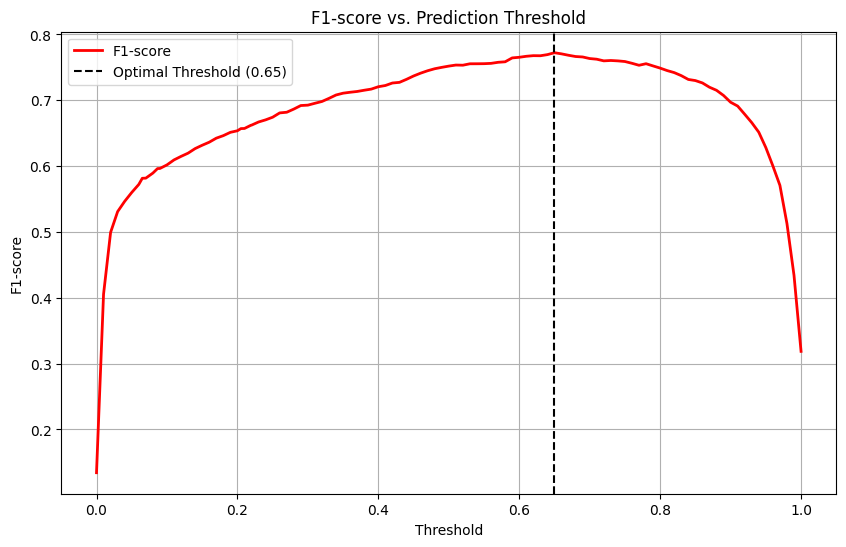

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Re-train Your Best Model ---
# This is your champion model: the original, untuned Random Forest.
# We train it on the balanced data to ensure it's ready.
print("Training the champion Random Forest model...")
champion_rf_model = RandomForestClassifier(random_state=42)
champion_rf_model.fit(X_train_res, y_train_res)
print("✅ Model training complete.")

# --- 2. Find the Optimal Threshold ---
print("\n--- Finding Optimal Threshold ---")

# Get the prediction probabilities for the 'Fraud' class on the test set
y_pred_proba = champion_rf_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate the F1-score for each threshold
# We add a small value (1e-6) to the denominator to prevent division by zero
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-6)

# Find the threshold that results in the highest F1-score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"\nBest Threshold: {best_threshold:.4f}")
print(f"🚀 Best Possible F1-score with this model: {best_f1_score:.4f}\n")

# --- 3. Evaluate Performance with the Optimal Threshold ---
# Apply the best threshold to the probabilities to get the final predictions
new_predictions = (y_pred_proba >= best_threshold).astype(int)

print("--- Final Performance with Optimal Threshold ---")
print("New Classification Report:")
print(classification_report(y_test, new_predictions))
print("\nNew Confusion Matrix:")
print(confusion_matrix(y_test, new_predictions))

# --- 4. Visualization ---
plt.figure(figsize=(10, 6))
# We plot against a slice of thresholds to match the length of f1_scores
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1-score', linewidth=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Optimal Threshold ({best_threshold:.2f})')
plt.title('F1-score vs. Prediction Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)
plt.show()

**Threshold Tuning LR**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import numpy as np

# --- 1. Re-train your best Logistic Regression model ---
# This is the original model, as it had the best F1-score on the test set.
best_lr_model = LogisticRegression(solver='liblinear', random_state=42)
best_lr_model.fit(X_train_res, y_train_res)

# --- 2. Find the Optimal Threshold ---
print("--- Finding Optimal Threshold for Logistic Regression ---")

# Get the prediction probabilities for the 'Fraud' class
y_pred_proba = best_lr_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1-scores for each threshold to find the best one
f1_scores = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)

print(f"\nBest Threshold: {best_threshold:.4f}")
print(f"🚀 Best Possible F1-score with this model: {best_f1_score:.4f}\n")

# --- 3. Evaluate performance with the new threshold ---
# Apply the new threshold to get the final predictions
new_predictions = (y_pred_proba >= best_threshold).astype(int)

print("--- Final Performance with Optimal Threshold ---")
print("New Classification Report:")
print(classification_report(y_test, new_predictions))

--- Finding Optimal Threshold for Logistic Regression ---

Best Threshold: 0.6966
🚀 Best Possible F1-score with this model: 0.7118

--- Final Performance with Optimal Threshold ---
New Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     18558
           1       0.66      0.77      0.71      1438

    accuracy                           0.95     19996
   macro avg       0.82      0.87      0.84     19996
weighted avg       0.96      0.95      0.96     19996



**Saving Final Model**

In [28]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# --- 1. Re-train your best model on the balanced data ---
original_rf_model = RandomForestClassifier(random_state=42)
original_rf_model.fit(X_train_res, y_train_res)

# --- 2. Define File Paths ---
# Use '../' to save to the main project directory
model_path = '../fraud_detection_model.joblib'
# We don't need a scaler_path

# --- 3. Save the Model and Scaler ---
# ADDED: compress=1 to reduce the model's file size.
joblib.dump(original_rf_model, model_path, compress=1) 
# We DO NOT save a scaler

# --- 4. Define the Optimal Threshold ---
optimal_threshold = 0.6500

# --- 5. Print Confirmation ---
print(f"✅ Best model (compressed) saved to: {model_path}")
print(f"✅ Remember to use the optimal threshold of {optimal_threshold} in your API!")

✅ Best model (compressed) saved to: ../fraud_detection_model.joblib
✅ Remember to use the optimal threshold of 0.65 in your API!
